# HSBC Mayweek Hackathon


## In Depth : Understanding USDINR NDF Orderbook Microstructure

The electronic Non-Deliverable Forwards market has grown over the past 2 years on EBS, the primary market for FX. Electronic liquidity traded inter-bank has gradually increased. Recently, the platform has opened to non-bank market participants. As a result, understanding the NDF price formation process in the presence of high frequency participants has become increasingly important as a Tier1 bank market-maker operating in the electronic market. In the analysis below, we build a supervised learning model , predicting the direction of the next price variation given a set of features, engineered from market orderbook data. The currency pair is the Indian rupee traded against US dollar.   Our goal is to build a predictive model to answer the following question

$$ \textit{The next time the price moves will it go up or down?}$$


## Fetch and plot historical USDINR Non Deliverable Forwards prices  

In [10]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 100

from_date = '2017.09.15'
to_date = '2017.09.30'
start_time = '03:00'
end_time = '15:00'

sym = '`USDINR'
site = "`LOH"

# load data from csv file (stratpy not available)
prices_raw = pd.read_csv("./prices_raw.csv")

# parse timestamps correctly
for t in [u'date' , u'ebsMarketUpdateTime', u'feedHandlerPublishTime', u'feedHandlerReceiveTime', u'eventCaptureTime']:
    prices_raw[t] = pd.to_datetime(prices_raw[t])
    
print("First three rows of raw data")
prices_raw.head(3)

First three rows of raw data


,Unnamed: 0,index,date,sym,time,siteCode,instrument,status,ebsReferenceTime,ebsMarketUpdateTime,feedHandlerReceiveTime,feedHandlerPublishTime,eventCaptureTime,bid,ask,paid,given,bidRegular,askRegular,regularSize,bid2,bid3,bidSize1,bidSize2,bidSize3,numberBidMaker1,numberBidMaker2,numberBidMaker3,ask2,ask3,askSize1,askSize2,askSize3,numberAskMaker1,numberAskMaker2,numberAskMaker3
0,0,0,2017-09-15,USDINR,0 days 03:00:15.501000000,LOH,USDINR1M=EBSNDF,ok,NaN,2017-09-15 03:00:15.341,2017-09-15 03:00:15.341,2017-09-15 03:00:15.341,2017-09-15 03:00:15.362,64.36,64.37,NaN,0.0,NaN,NaN,NaN,64.33,64.31,1000000,1000000,1000000,1,1,1,64.405,64.520,1000000,1000000,22000000,1,1,1
1,1,1,2017-09-15,USDINR,0 days 03:00:15.901000000,LOH,USDINR1M=EBSNDF,ok,NaN,2017-09-15 03:00:15.841,2017-09-15 03:00:15.841,2017-09-15 03:00:15.841,2017-09-15 03:00:15.862,64.36,64.37,NaN,0.0,NaN,NaN,NaN,64.33,64.31,1000000,1000000,1000000,1,1,1,64.400,64.405,1000000,1000000,1000000,1,1,1
2,2,2,2017-09-15,USDINR,0 days 03:00:24.706000000,LOH,USDINR1M=EBSNDF,ok,NaN,2017-09-15 03:00:24.594,2017-09-15 03:00:24.594,2017-09-15 03:00:24.594,2017-09-15 03:00:24.635,64.36,64.37,NaN,0.0,NaN,NaN,NaN,64.33,64.31,1000000,1000000,1000000,1,1,1,64.400,64.410,1000000,1000000,1000000,1,1,1


### Timestamp Information

- date : day the update happeed
- time : final time data was written to database
- ebsMarketUpdateTime : market updates
- feedHandlerPublishTime : data was published by feedhandler
- feedHandlerReceiveTime : data was first received by feedhandler
- eventCaptureTime : N/A

in theory 

                ebsMarketUpdateTime < feedHandlerReceiveTime < feedHandlerPublishTime

In [11]:
T = [u'date' , u'time' , u'ebsMarketUpdateTime', u'feedHandlerPublishTime', u'feedHandlerReceiveTime', u'eventCaptureTime']
timeDeltas = prices_raw[T]
timeDeltas['marketLatency'] = timeDeltas['feedHandlerReceiveTime'] - timeDeltas['ebsMarketUpdateTime']
timeDeltas['processLatency'] = timeDeltas['feedHandlerPublishTime'] - timeDeltas['feedHandlerReceiveTime']

timeDeltas[['marketLatency','processLatency',]].describe().T[['mean','std','max']]

,mean,std,max
marketLatency,0 days 00:00:00.000202,0 days 00:00:00.000415,0 days 00:00:00.017000
processLatency,0 days 00:00:00.000097,0 days 00:00:00.000308,0 days 00:00:00.021000


### Numerical Information

- index : sequence number for update
- bid,bid2,bid3 : prices people are willing to buy at. (Ruppees per Dollar)
- bidSize,bidSize2,bidSize3 : volumes people are willing to buy. (in Dollars)
- ask,ask2,ask3 : prices people are willing to sell at. (Ruppees per Dollar)
- askSize,askSize2,askSize3 : volumes people are willing to sell. (in Dollars)
- paid : last price someone paid on the ask side to trade. (Ruppees per Dollar)
- given : last price someone paid on the bid side to trade. (Ruppees per Dollar)

*** note the given data looks a bit odd?

In [12]:
N=[u'index', u'bid', u'ask', u'paid', u'given', u'bid2', u'bid3', u'bidSize1',\
   u'bidSize2', u'bidSize3', u'ask2', u'ask3', u'askSize1',u'askSize2', u'askSize3']

prices_raw[N].describe().T

,count,mean,std,min,25%,50%,75%,max
index,231154.0,1.155765e+05,6.672856e+04,0.000,57788.250,115576.500,173364.750,2.311530e+05
bid,231154.0,6.528029e+01,5.578074e-01,64.215,64.930,65.345,65.705,6.619000e+01
ask,231154.0,6.529080e+01,5.588692e-01,64.220,64.940,65.360,65.720,6.625000e+01
paid,6207.0,6.530812e+01,5.544746e-01,64.220,64.985,65.350,65.745,6.619500e+01
given,200740.0,1.883762e+00,1.093503e+01,0.000,0.000,0.000,0.000,6.619000e+01
bid2,231154.0,6.518508e+01,2.471577e+00,0.000,64.915,65.340,65.700,6.618000e+01
bid3,231154.0,6.495080e+01,4.564042e+00,0.000,64.885,65.335,65.690,6.617500e+01
bidSize1,231154.0,2.705962e+06,2.804288e+06,1000000.000,1000000.000,2000000.000,3000000.000,6.500000e+07
bidSize2,231154.0,4.264624e+06,4.190954e+06,0.000,2000000.000,3000000.000,5000000.000,7.300000e+07
bidSize3,231154.0,4.082067e+06,4.296730e+06,0.000,2000000.000,3000000.000,5000000.000,7.200000e+07


Let's plot an orderbook snapshot.

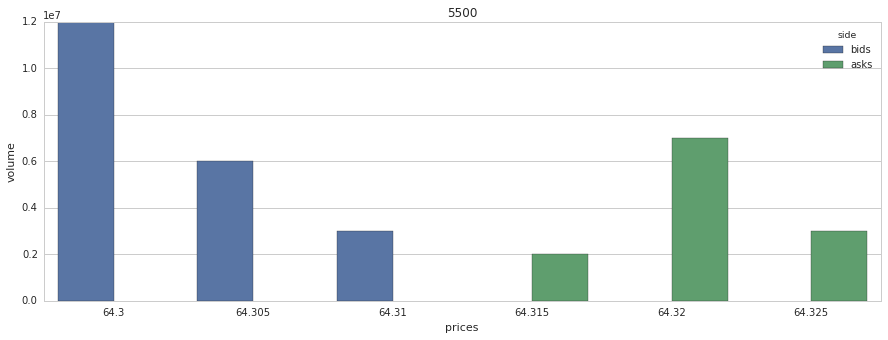

In [13]:
snapshot = prices_raw.iloc[5500]
orderbook = pd.DataFrame([{'prices':snapshot['bid'],'volume': snapshot['bidSize1'], 'side': 'bids'},
                            {'prices':snapshot['bid2'],'volume': snapshot['bidSize2'], 'side': 'bids'},
                            {'prices':snapshot['bid3'],'volume': snapshot['bidSize3'], 'side': 'bids'},
                            {'prices':snapshot['ask'],'volume': snapshot['askSize1'], 'side' : 'asks'},
                            {'prices':snapshot['ask2'],'volume': snapshot['askSize2'], 'side' : 'asks'},
                            {'prices':snapshot['ask3'],'volume': snapshot['askSize3'], 'side' : 'asks'}])

plt.figure(figsize=(15,5))
ax = sns.barplot(x="prices", y="volume", data=orderbook, hue = 'side')
ax.set_title(snapshot.name)
plt.show()

## Data pre-processing

We keep a subset of columns and index the dataframe by _feedHandlerReceiveTime_

In [14]:
prices = prices_raw[['date','bid','ask','bid2','ask2','bidSize1','askSize1','bidSize2','askSize2','paid', 'given']]

prices['bid'] = prices['bid'].replace(0,np.NaN)
prices['ask'] = prices['ask'].replace(0,np.NaN)
prices['bid2'] = prices['bid2'].replace(0,np.NaN)
prices['ask2'] = prices['ask2'].replace(0,np.NaN)

prices['paid'] = prices['paid'].replace(0,np.NaN)
prices['given'] = prices['given'].replace(0,np.NaN)
prices['mid'] =  prices['ask']
prices['mid'] = 0.5*(prices['bid'] + prices['mid'])

prices.index = prices_raw.feedHandlerReceiveTime

We only keep the first of duplicated updates.

In [15]:
prices=prices.drop_duplicates()

Let's have a look at the resulting data.

In [16]:
prices[10010:10015]

,date,bid,ask,bid2,ask2,bidSize1,askSize1,bidSize2,askSize2,paid,given,mid
feedHandlerReceiveTime,,,,,,,,,,,,
2017-09-18 10:09:16.541,2017-09-18,64.38,64.390,64.375,64.395,1000000,5000000,4000000,3000000,NaN,NaN,64.3850
2017-09-18 10:09:17.292,2017-09-18,64.38,64.385,64.375,64.390,1000000,2000000,4000000,5000000,NaN,NaN,64.3825
2017-09-18 10:09:17.543,2017-09-18,64.38,64.390,64.375,64.395,1000000,4000000,3000000,3000000,64.385,NaN,64.3850
2017-09-18 10:09:17.791,2017-09-18,64.38,64.390,64.375,64.395,1000000,3000000,3000000,3000000,NaN,NaN,64.3850
2017-09-18 10:09:18.042,2017-09-18,64.38,64.390,64.375,64.395,1000000,3000000,4000000,3000000,NaN,NaN,64.3850


Plotting the following descriptive statistics :<br>
>the number of prices updates per day<br>
>the number of reported trades per day<br>
>the daily average price level<br>
>the daily average visible liquidity on the first 2 levels of the orderbook<br>
>the mid price for a specific date (2017.09.15)

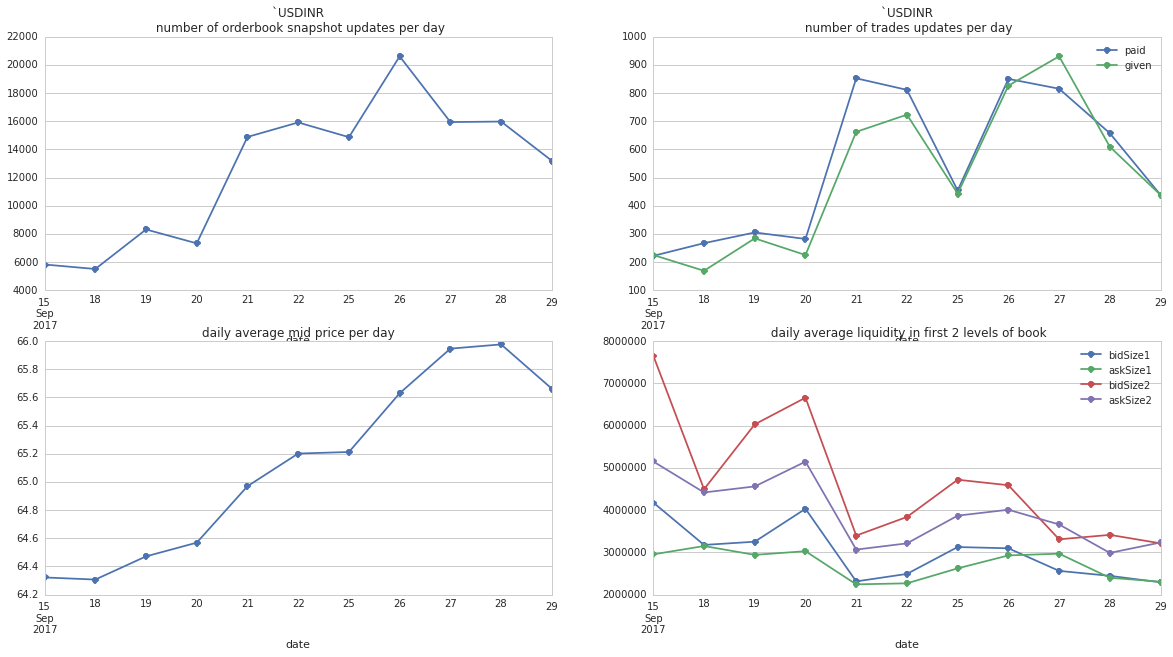

In [17]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
prices.groupby('date')['mid'].count().plot(ax = axes[0,0],title = sym+' \n number of orderbook snapshot updates per day', style = 'o-')
prices.groupby('date')['paid','given'].count().plot(ax = axes[0,1],title = sym+' \n number of trades updates per day', style = 'o-')
prices.groupby('date')['mid'].mean().plot(ax = axes[1,0],title = 'daily average mid price per day', style = 'o-')
prices.groupby('date')[['bidSize1','askSize1','bidSize2','askSize2']].mean().plot(ax = axes[1,1],title = ' daily average liquidity in first 2 levels of book', style = 'o-')
plt.show()

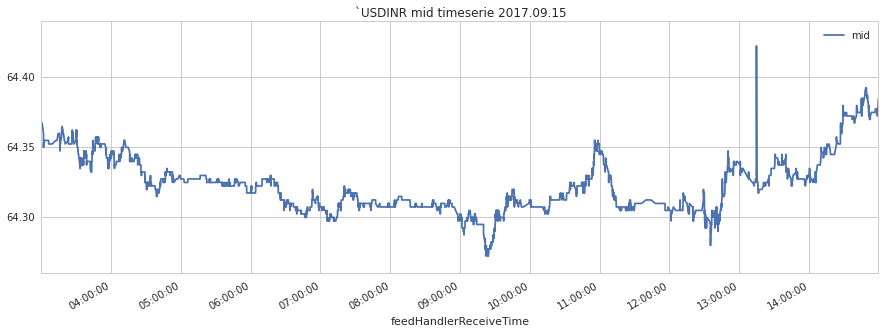

In [18]:
date = '2017.09.15'
prices['date'] = pd.to_datetime(prices.date)
prices[prices['date']==date][['mid']].plot(figsize=(15,5), title=sym+ ' mid timeserie '+date)
plt.show()

## Features Engineering

Our problem is a supervised learning classification problem. The features are derived values of the order book delta updates along with transformation of market trades.

Include the orderbook deltas

In [19]:
columns = ['bid','ask','bid2','ask2','bidSize1','askSize1','bidSize2','askSize2','mid']
prices_delta = prices[columns] - prices[columns].shift(1)
prices_delta.rename(columns = {'mid':'deltaMid','bid':'deltaBid','ask':'deltaAsk','bidSize1':'deltaBidSize1','askSize1':'deltaAskSize1',
                              'bidSize2':'deltaBidSize2','askSize2':'deltaAskSize2'}, inplace=True)

# add back old prices, and a midDiff for learning later
LL = ['mid','bid','ask','bidSize1','bidSize2','askSize1','askSize2']
prices_delta[LL] = prices[LL]
prices_delta['midDiffInterval'] = (prices_delta['deltaMid'] != 0).cumsum()

# drop some features
LLL = ['bid2','ask2','bidSize2','askSize2','deltaBidSize2','deltaAskSize2']
for l in LLL:
    prices_delta.drop(l,1,inplace=True)

Verify the resulting prices and values

In [20]:
prices_delta.head(10)

,deltaBid,deltaAsk,deltaBidSize1,deltaAskSize1,deltaMid,mid,bid,ask,bidSize1,askSize1,midDiffInterval
feedHandlerReceiveTime,,,,,,,,,,,
2017-09-15 03:00:15.341,NaN,NaN,NaN,NaN,NaN,64.3650,64.360,64.370,1000000,1000000,1
2017-09-15 03:00:15.841,0.000,0.000,0.0,0.0,0.0000,64.3650,64.360,64.370,1000000,1000000,1
2017-09-15 03:00:26.094,0.005,0.000,0.0,0.0,0.0025,64.3675,64.365,64.370,1000000,1000000,2
2017-09-15 03:00:27.093,0.000,0.000,0.0,0.0,0.0000,64.3675,64.365,64.370,1000000,1000000,2
2017-09-15 03:00:28.842,0.000,0.000,1000000.0,0.0,0.0000,64.3675,64.365,64.370,2000000,1000000,2
2017-09-15 03:00:46.841,0.000,0.000,0.0,0.0,0.0000,64.3675,64.365,64.370,2000000,1000000,2
2017-09-15 03:02:01.092,-0.010,-0.005,-1000000.0,2000000.0,-0.0075,64.3600,64.355,64.365,1000000,3000000,3
2017-09-15 03:02:02.091,-0.020,0.000,0.0,0.0,-0.0100,64.3500,64.335,64.365,1000000,3000000,4
2017-09-15 03:02:03.092,0.000,0.000,1000000.0,0.0,0.0000,64.3500,64.335,64.365,2000000,3000000,4


We calculate the following __features__ : <br> 
>the distance between the last traded price and the current mid<br>
>the top of book sizes<br>
>the prior mid variation<br>
>the prior top of book size variation<br>
>a book pressure signal<br>
>the bid-offer spread<br>

In [21]:
# time feature (on feedHandlerRecieve), date,time ... 
prices_delta['date'] = prices.date
prices_delta['time'] = prices.index

# trade Features, print,tradeSeq,lastPaid,lastGiven,bidToPaid,bidToGiven,midToPaid ...
atomicTrades = prices[['paid','given']].loc[(prices['paid']>1) | (prices['given']>1)]
atomicTrades.loc[atomicTrades['paid'] <1, 'paid' ] = np.NaN
atomicTrades.loc[atomicTrades['given'] <1, 'given' ] = np.NaN
atomicTrades = atomicTrades.replace(0,np.NaN)
prices_delta['paid'] = atomicTrades['paid']
prices_delta['given'] = atomicTrades['given']
prices_delta['print'] = np.where((prices_delta['paid']>1) | (prices_delta['given']>1),1,0)
prices_delta['tradeSeq'] = prices_delta['print'].cumsum()
prices_delta['lastPaid'] = prices_delta['paid'].ffill()
prices_delta['lastGiven'] = prices_delta['given'].ffill()
prices_delta.drop('paid',1,inplace=True)
prices_delta.drop('given',1,inplace=True)
prices_delta['midToPaid'] = prices_delta['mid'] - prices_delta['lastPaid']
prices_delta['midToGiven'] = prices_delta['mid'] - prices_delta['lastGiven']
prices_delta['bidToPaid'] = prices_delta['bid'] - prices_delta['lastPaid']
prices_delta['bidToGiven'] = prices_delta['bid'] - prices_delta['lastGiven']
prices_delta['askToPaid'] = prices_delta['ask'] - prices_delta['lastPaid']
prices_delta['askToGiven'] = prices_delta['ask'] - prices_delta['lastGiven']

# book preasure feature
prices['book_pressure'] = prices['mid'] - (prices['bidSize1']*prices['bid'] + prices['askSize1']*prices['ask'])/(prices['bidSize1']+prices['askSize1'])
prices_delta['book_pressure'] = prices['mid'] - (prices['bidSize1']*prices['bid'] + prices['askSize1']*prices['ask'])/(prices['bidSize1']+prices['askSize1'])

# spread feature
prices_delta['spread'] = prices_delta['ask'] - prices_delta['bid']

# create feature to learn, ie next move (not to be used as covariates!)
prices_delta['midDiff'] = prices_delta['mid'].diff()
prices_delta['nextMidDiff'] = prices_delta['midDiff'].shift(-1)
prices_delta['nextMidVariation'] = prices_delta['nextMidDiff'].replace(to_replace=0, method='bfill')

prices_delta.dropna(inplace=True)

Let's review the processed data. the matrix of features is sparse. We replace all zeros by NaN tocalculate meaningful statistics using pandas.

In [22]:
prices_delta = prices_delta.replace(0,np.NaN)

In [23]:
import functions as func
func.formatdf(prices_delta.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
deltaBid,"17,667",0.00,0.01,-0.12,-0.00,0.00,0.00,0.17
deltaAsk,"18,680",0.00,0.01,-0.30,-0.00,-0.00,0.00,0.31
deltaBidSize1,"46,037",0.00,"2,943,896","-64,000,000","-1,000,000","1,000,000","1,000,000","64,000,000"
deltaAskSize1,"45,765",-21.85,"2,577,354","-33,000,000","-1,000,000","1,000,000","1,000,000","34,000,000"
deltaMid,"32,414",0.00,0.01,-0.14,-0.00,0.00,0.00,0.20
mid,"138,293",65.31,0.55,64.22,65.00,65.38,65.73,66.22
bid,"138,293",65.31,0.55,64.22,65.00,65.37,65.72,66.19
ask,"138,293",65.32,0.55,64.22,65.00,65.38,65.73,66.25
bidSize1,"138,293","2,838,994","2,952,055","1,000,000","1,000,000","2,000,000","3,000,000","65,000,000"
askSize1,"138,293","2,644,863","2,445,175","1,000,000","1,000,000","2,000,000","3,000,000","51,000,000"


We remove the prices variations outliers using __stats__ in __scipy__ 

In [24]:
prices_delta = prices_delta.replace(np.NaN,0)
prices_delta_clean = prices_delta[(np.abs(stats.zscore(prices_delta['deltaMid'])) < 5)]
prices_delta_clean = prices_delta_clean.replace(0,np.NaN)
prices_delta_clean = prices_delta_clean.replace(np.NaN,0)

Let's label the dataset and train a classification learning algorithm.

In [25]:
features = ['deltaBid','deltaAsk','deltaMid','midToPaid','midToGiven','bidSize1','askSize1','bidToPaid','askToGiven','bidToGiven','askToPaid', 'book_pressure','spread']

OUT = (prices_delta_clean.date == '2017.09.29') | (prices_delta_clean.date == '2017.09.28') 
OUT = OUT | (prices_delta_clean.date == '2017.09.27') 
IN = ~OUT

X_train = np.array(prices_delta_clean[IN][features].values)
y_train = np.array(prices_delta_clean[IN]['nextMidVariation'].values)
X_test = np.array(prices_delta_clean[OUT][features].values)
y_test = np.array(prices_delta_clean[OUT]['nextMidVariation'].values)

y_train[y_train<0] = -1
y_train[y_train>0] = 1
y_test[y_test<0] = -1
y_test[y_test>0] = 1

## Fitting a Predictive Model

In [26]:
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import sparse
import keras

np.random.seed(437)

Using TensorFlow backend.


Decision Tree Classifier

0.550851982026
             precision    recall  f1-score   support

       -1.0       0.55      0.58      0.57     22761
        1.0       0.55      0.52      0.53     22193

avg / total       0.55      0.55      0.55     44954



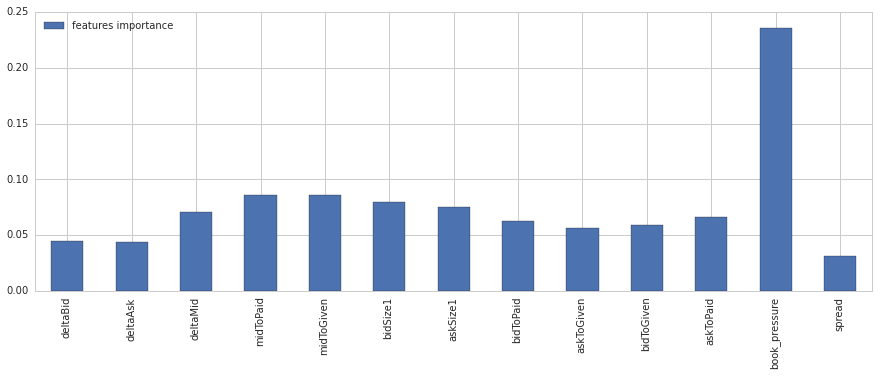

In [27]:
clf = DecisionTreeClassifier()

clf.fit(sparse.csr_matrix(X_train), y_train)
predictions = clf.predict(sparse.csr_matrix(X_test))
print(metrics.accuracy_score(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

features_importance = pd.DataFrame(index = features, data={'features importance':clf.feature_importances_})
features_importance.plot(kind='bar', figsize=(15,5))
plt.show()